<a href="https://colab.research.google.com/github/WNderitu/data_science_capstone_project/blob/main/Malaria_parasite_detector_and_counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plasmodium Vivax (malaria) parasite detector and counter**


## **1.0 Introduction**

Malaria, a life-threatening disease caused by Plasmodium parasites transmitted by female Anopheles mosquitoes, is most commonly found in tropical and subtropical regions. In 2023, the African Region was home to 94% and 95% of malaria cases and deaths, respectively. Sub-Saharan Africa carries a disproportionately high share of the global malaria burden. Plasmodium vivax is one of the 5 parasites that cause malaria associated with disease relapses due to dormant liver stages, contributing significantly to morbidity.

The Plasmodium vivax lifecycle alternates between humans and Anopheles mosquitoes. Infection begins when a mosquito injects sporozoites into a human, which then move to the liver to either develop or remain dormant. Merozoites released from the liver infect red blood cells, progressing through ring, trophozoite, and schizont stages, causing malaria symptoms. Some parasites develop into gametocytes, enabling further transmission via mosquitoes.

Diagnosis of Plasmodium vivax malaria relies on examining stained blood smears via microsocopy and rapid diagnostic tests, with accurate detection being key to effective treatment and relapse prevention. Advanced methods like deep learning models, such as Regional Based CNN, YOLOv8, and others would offer improved reliability and efficiency in identifying infections.

## **1.1 Problem Statement**

The detection of Plasmodium vivax malaria remains challenging, primarily due to the morphological similarities between parasite stages and other blood components observed in microscopic images. Conventional microscopy is a labor-intensive process that is susceptible to human error and demands specialized expertise, which may be limited in under-resourced settings. Consequently, there is an urgent need for automated, efficient, and dependable solutions capable of detecting and quantifying Plasmodium vivax parasites and their developmental stages within blood smears. Such advancements would enhance diagnostic accuracy, promote effective treatment, and strengthen malaria control initiatives.

## **1.2 Objectives**



1.   To develop a computer vision model for object detection and counting
2.   To detect uninfected red blood cells and leukocytes in human blood cells in a microscopic image from a blood smear using the developed YOLOv8 model
3. To count the number of uninfected red blood cells and leukocytes in human blood cells in a microscpic image from a blood smear using the developed YOLOv8 model
4. To detect the growth stage of a Plasmodium Vivax (malaria parasite) in human blood cells in a microscopic image from a blood smear using the developed YOLOv8 model
5. To count the number of detected growth stages of the plasmodium vivax parasites per microscopic image using the developed YOLOv8 model

## **1.3 Installing & Importing Required Libraries**

In [4]:
!pip install matplotlib

In [5]:
!pip install Pillow #installing PILLOW LIBRARY

In [172]:
!pip uninstall Pillow -y
!pip install Pillow

Found existing installation: pillow 12.0.0
Uninstalling pillow-12.0.0:
  Successfully uninstalled pillow-12.0.0
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


In [6]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 18.1 MB/s eta 0:00:00


In [7]:
!pip install pyyaml

In [9]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.5 MB/s eta 0:00:00


In [148]:
import requests
import os
import json
import random
import shutil
from pprint import pprint # for
import PIL
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from collections import Counter
import hashlib # find identical images
from collections import defaultdict
import numpy as np
import math # for
import yaml
from collections import Counter # Import Counter to get class counts
import shutil # for creating directories

## **1.4 Image dataset**

Dataset sourced from: https://bbbc.broadinstitute.org/BBBC041/

The dataset consists of:

image folder

training json file

test json file

The dataset consists of 1,328 microscopic images of blood smears

### **1.4.1 Downloading image dataset from website**

In [174]:
url = "https://bbbc.broadinstitute.org/BBBC041/"
response = requests.get(url)

if response.status_code == 200:
    print("Successfully accessed the URL.") # Parse the HTML content here to find the actual data file links.
else:
    print(f"Failed to access the URL. Status code: {response.status_code}")

Successfully accessed the URL.


In [175]:
from bs4 import BeautifulSoup
# Use BeautifulSoup & find links to data files and download them.

# Assuming 'response' from the previous cell contains the HTML content
if 'response' in locals() and response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all links on the page
    links = soup.find_all('a')

    # Filter for links that seem to be data files (e.g., ending with .zip, .csv, etc.)
    # This is a generic approach and might need adjustment based on the actual website structure
    data_links = [link.get('href') for link in links if link.get('href') and (link.get('href').endswith('.zip') or link.get('href').endswith('.csv'))]

    # Create a directory to save the downloaded files if it doesn't exist
    download_dir = "downloaded_data"
    os.makedirs(download_dir, exist_ok=True)

    print(f"Found {len(data_links)} potential data files.")

    # Download each data file
    for data_link in data_links:
        # Construct the full URL if the link is relative
        if not data_link.startswith('http'):
            full_url = url + data_link
        else:
            full_url = data_link

        file_name = os.path.join(download_dir, os.path.basename(full_url))

        try:
            print(f"Downloading {full_url} to {file_name}...")
            with requests.get(full_url, stream=True) as r:
                r.raise_for_status()
                with open(file_name, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print("Download complete.")
        except requests.exceptions.RequestException as e:
            print(f"Error downloading {full_url}: {e}")

else:
    print("Could not proceed with downloading data. Please ensure the previous cell successfully accessed the URL.")

Found 1 potential data files.
Download complete.


### **1.4.2 Extract contents of downloaded zip file & inspect structure of image dataset files**

In [176]:
# extract contents of zip file
import zipfile

zip_file_path = 'downloaded_data/malaria.zip'
extract_dir = 'malaria_data'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully extracted {zip_file_path} to {extract_dir}")
except FileNotFoundError:
    print(f"Error: The file {zip_file_path} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_file_path} is not a valid zip file.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted downloaded_data/malaria.zip to malaria_data


In [14]:
# List the contents of the 'malaria' directory
malaria_dir_contents = os.listdir('malaria_data/malaria')
print("Contents of malaria_data/malaria/:")
for item in malaria_dir_contents:
    print(item)

Contents of malaria_data/malaria/:
test.json
images
training.json


In [19]:
# rename training json to train json
old_name = 'malaria_data/malaria/training.json'
new_name = 'malaria_data/malaria/train.json'

try:
    os.rename(old_name, new_name)
    print(f"Successfully renamed {old_name} to {new_name}")
except FileNotFoundError:
    print(f"Error: The file {old_name} was not found.")
except FileExistsError:
    print(f"Error: A file named {new_name} already exists.")
except Exception as e:
    print(f"An error occurred during renaming: {e}")

Successfully renamed malaria_data/malaria/training.json to malaria_data/malaria/train.json


In [21]:
# Check contents of train json file
train_json_path = 'malaria_data/malaria/train.json'

try:
    with open(train_json_path, 'r') as f:
        train_data = json.load(f)

    print(f"Contents of {train_json_path} (first entry):")
    if train_data:
        pprint(train_data[0])
    else:
        print("The train.json file is empty.")

except FileNotFoundError:
    print(f"Error: The file {train_json_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {train_json_path}. Please check the file format.")
except Exception as e:
    print(f"An error occurred: {e}")

Contents of malaria_data/malaria/train.json (first entry):
{'image': {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af',
           'pathname': '/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png',
           'shape': {'c': 1600, 'channels': 3, 'r': 1200}},
 'objects': [{'bounding_box': {'maximum': {'c': 1540, 'r': 1158},
                               'minimum': {'c': 1440, 'r': 1057}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c': 1403, 'r': 971},
                               'minimum': {'c': 1303, 'r': 868}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c': 1008, 'r': 689},
                               'minimum': {'c': 900, 'r': 578}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c': 713, 'r': 408},
                               'minimum': {'c': 611, 'r': 304}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'

The train.json file contains annotations for different objects within the images, including their categories and bounding boxes as a list. Each entry represents an image and it's annotations and is a dictionary with two main keys:

- **'image'**: This dictionary contains information about the image, such as:
  - **'checksum'**: A unique identifier for the image file
  - **'pathname'**: The path to the image file (relative to the dataset's image directory).
  - **'shape'**: The dimensions of the image (columns c and rows r), and the number of channels.

- **'objects'**: This is a list of dictionaries, where each dictionary represents a detected object within the image. Each object dictionary contains:
  - **'bounding_box'**: A dictionary specifying the coordinates of the bounding box around the object. It has:
      - **'maximum'**: A dictionary with the maximum column (c) and row (r) coordinates of the bounding box.
      - **'minimum'**: A dictionary with the minimum column (c) and row (r) coordinates of the bounding box.
  - **'category'**: A string indicating the class or type of the object detected (e.g., 'red blood cell', 'trophozoite').

In [22]:
# Check contents of test json file
test_json_path = 'malaria_data/malaria/test.json'

try:
    with open(test_json_path, 'r') as f:
        test_data = json.load(f)

    print(f"Contents of {test_json_path} (first entry):")
    if test_data:
        pprint(train_data[0])
    else:
        print("The test.json file is empty.")

except FileNotFoundError:
    print(f"Error: The file {test_json_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {test_json_path}. Please check the file format.")
except Exception as e:
    print(f"An error occurred: {e}")

Contents of malaria_data/malaria/test.json (first entry):
{'image': {'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af',
           'pathname': '/images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png',
           'shape': {'c': 1600, 'channels': 3, 'r': 1200}},
 'objects': [{'bounding_box': {'maximum': {'c': 1540, 'r': 1158},
                               'minimum': {'c': 1440, 'r': 1057}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c': 1403, 'r': 971},
                               'minimum': {'c': 1303, 'r': 868}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c': 1008, 'r': 689},
                               'minimum': {'c': 900, 'r': 578}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c': 713, 'r': 408},
                               'minimum': {'c': 611, 'r': 304}},
              'category': 'red blood cell'},
             {'bounding_box': {'maximum': {'c

same as for train json file

In [40]:
# Get number of test and train images

# Assuming train_data and test_data are available from previous cell executions
if 'train_data' in locals():
    num_train_images = len(train_data)
    print(f"Number of images in the train dataset: {num_train_images}")
else:
    print("Train data not loaded. Please run the cell that loads 'train.json'.")

if 'test_data' in locals():
    num_test_images = len(test_data)
    print(f"Number of images in the test dataset: {num_test_images}")
else:
    print("Test data not loaded. Please run the cell that loads 'test.json'.")

Number of images in the train dataset: 1208
Number of images in the test dataset: 120


In [42]:
image_folder_path = 'malaria_data/malaria/images'

try:
    # List all files in the image folder
    image_files = os.listdir(image_folder_path)

    # Count the number of files (assuming all are images)
    num_total_images = len(image_files)

    print(f"Total number of images in the image folder: {num_total_images}")

except FileNotFoundError:
    print(f"Error: The image folder was not found at {image_folder_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Total number of images in the image folder: 1328


## **1.5 Data cleaning & inspection of images**

### **1.5.1 Split & move images in image folder into 2 folders: test & train images**

In [177]:
# create the test and train folders
base_image_dir = 'malaria_data/malaria/images'
train_image_dir = os.path.join(base_image_dir, 'train')
test_image_dir = os.path.join(base_image_dir, 'test')

# Create the directories if they don't exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)

print(f"Created directory: {train_image_dir}")
print(f"Created directory: {test_image_dir}")

Created directory: malaria_data/malaria/images/train
Created directory: malaria_data/malaria/images/test


In [179]:
# Load the training and testing data
train_json_path = 'malaria_data/malaria/train.json'
test_json_path = 'malaria_data/malaria/test.json'
# Corrected base_image_dir to point to the directory containing the 'images' folder
base_dir = 'malaria_data/malaria'
train_image_dir = os.path.join(base_dir, 'images', 'train')
test_image_dir = os.path.join(base_dir, 'images', 'test')

# Create the directories if they don't exist (already done in a previous cell, but good to ensure)
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)


try:
    with open(train_json_path, 'r') as f:
        train_data = json.load(f)
    with open(test_json_path, 'r') as f:
        test_data = json.load(f)

    # Move training images
    print("Moving training images...")
    for entry in train_data:
        image_pathname = entry['image']['pathname']
        # Construct the source path correctly
        source_path = os.path.join(base_dir, image_pathname.lstrip('/')) # Use base_dir and lstrip to handle /images/
        destination_path = os.path.join(train_image_dir, os.path.basename(image_pathname)) # Use basename to get just the file name


        try:
            shutil.move(source_path, destination_path)
        except FileNotFoundError:
            print(f"Warning: Image file not found for training data at {source_path}")
        except Exception as e:
            print(f"An error occurred while moving training image {source_path}: {e}")

    # Move testing images
    print("Moving testing images...")
    for entry in test_data:
        image_pathname = entry['image']['pathname']
        # Construct the source path correctly
        source_path = os.path.join(base_dir, image_pathname.lstrip('/')) # Use base_dir and lstrip to handle /images/
        destination_path = os.path.join(test_image_dir, os.path.basename(image_pathname)) # Use basename to get just the file name
        try:
            shutil.move(source_path, destination_path)
        except FileNotFoundError:
            print(f"Warning: Image file not found for testing data at {source_path}")
        except Exception as e:
            print(f"An error occurred while moving testing image {source_path}: {e}")

    print("Image separation complete.")

except FileNotFoundError as e:
    print(f"Error: JSON file not found: {e}")
except json.JSONDecodeError as e:
    print(f"Error: Could not decode JSON from file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error: JSON file not found: [Errno 2] No such file or directory: 'malaria_data/malaria/train.json'


In [50]:
# Move images into test and train folders

base_image_dir = 'malaria_data/malaria/images'
train_image_dir = os.path.join(base_image_dir, 'train')
test_image_dir = os.path.join(base_image_dir, 'test')

# Check the contents of the original images folder
print(f"Contents of the original images folder ({base_image_dir}):")
try:
    original_images_contents = os.listdir(base_image_dir)
    print(original_images_contents)
except FileNotFoundError:
    print(f"Error: The original images folder was not found at {base_image_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

# Check the number of files in the train image folder
print(f"\nNumber of images in the train folder ({train_image_dir}):")
try:
    num_train_files = len([f for f in os.listdir(train_image_dir) if os.path.isfile(os.path.join(train_image_dir, f))])
    print(num_train_files)
except FileNotFoundError:
    print(f"Error: The train image folder was not found at {train_image_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

# Check the number of files in the test image folder
print(f"\nNumber of images in the test folder ({test_image_dir}):")
try:
    num_test_files = len([f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))])
    print(num_test_files)
except FileNotFoundError:
    print(f"Error: The test image folder was not found at {test_image_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

# Compare with the counts from the JSON data (assuming train_data and test_data are available)
if 'train_data' in locals():
    num_train_images_from_json = len(train_data)
    print(f"\nNumber of images in train.json: {num_train_images_from_json}")
else:
    print("\nTrain data not loaded. Cannot compare with train.json count.")

if 'test_data' in locals():
    num_test_images_from_json = len(test_data)
    print(f"Number of images in test.json: {num_test_images_from_json}")
else:
    print("Test data not loaded. Cannot compare with test.json count.")

Contents of the original images folder (malaria_data/malaria/images):
['train', 'test']

Number of images in the train folder (malaria_data/malaria/images/train):
1208

Number of images in the test folder (malaria_data/malaria/images/test):
120

Number of images in train.json: 1208
Number of images in test.json: 120


### **1.5.2 Create a labels folder to contain the json files**

In [51]:
# Define the paths
base_dir = 'malaria_data/malaria'
labels_dir = os.path.join(base_dir, 'labels')
train_json_path = os.path.join(base_dir, 'train.json')
test_json_path = os.path.join(base_dir, 'test.json')

# Create the labels directory if it doesn't exist
os.makedirs(labels_dir, exist_ok=True)
print(f"Created directory: {labels_dir}")

# Move the train.json file
try:
    shutil.move(train_json_path, labels_dir)
    print(f"Moved {train_json_path} to {labels_dir}")
except FileNotFoundError:
    print(f"Error: {train_json_path} not found.")
except Exception as e:
    print(f"An error occurred while moving {train_json_path}: {e}")

# Move the test.json file
try:
    shutil.move(test_json_path, labels_dir)
    print(f"Moved {test_json_path} to {labels_dir}")
except FileNotFoundError:
    print(f"Error: {test_json_path} not found.")
except Exception as e:
    print(f"An error occurred while moving {test_json_path}: {e}")

Created directory: malaria_data/malaria/labels
Moved malaria_data/malaria/train.json to malaria_data/malaria/labels
Moved malaria_data/malaria/test.json to malaria_data/malaria/labels


### **1.5.3 Check if all images have corresponding image names in json files**

In [180]:
# Define paths
train_image_dir = 'malaria_data/malaria/images/train'
train_json_path = 'malaria_data/malaria/labels/train.json'

# Get the list of image filenames in the training directory
try:
    train_image_files = set(os.listdir(train_image_dir))
    # Filter out any non-file entries like subdirectories if necessary
    train_image_files = {f for f in train_image_files if os.path.isfile(os.path.join(train_image_dir, f))}

except FileNotFoundError:
    print(f"Error: Training image folder not found at {train_image_dir}")
    train_image_files = set()
except Exception as e:
    print(f"An error occurred while listing training images: {e}")
    train_image_files = set()


# Get the list of image pathnames from the train.json file
train_json_image_paths = set()
try:
    with open(train_json_path, 'r') as f:
        train_data = json.load(f)
    for entry in train_data:
        # Extract just the filename from the pathname
        image_filename = os.path.basename(entry['image']['pathname'])
        train_json_image_paths.add(image_filename)

except FileNotFoundError:
    print(f"Error: train.json file not found at {train_json_path}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {train_json_path}. Please check the file format.")
except Exception as e:
    print(f"An error occurred while reading train.json: {e}")

# Compare the two sets of filenames
images_not_in_json = train_image_files - train_json_image_paths
json_entries_not_in_images = train_json_image_paths - train_image_files

if not images_not_in_json and not json_entries_not_in_images:
    print("All images in the training folder have corresponding entries in train.json, and vice versa.")
else:
    if images_not_in_json:
        print(f"\nWarning: {len(images_not_in_json)} image files in the training folder do not have entries in train.json:")
        pprint(list(images_not_in_json)[:10]) # Print up to 10 for brevity
    if json_entries_not_in_images:
        print(f"\nWarning: {len(json_entries_not_in_images)} entries in train.json do not have corresponding image files in the training folder:")
        pprint(list(json_entries_not_in_images)[:10]) # Print up to 10 for brevity

All images in the training folder have corresponding entries in train.json, and vice versa.


In [181]:
# Define paths
test_image_dir = 'malaria_data/malaria/images/test'
test_json_path = 'malaria_data/malaria/labels/test.json' # Updated path

# Get the list of image filenames in the testing directory
try:
    test_image_files = set(os.listdir(test_image_dir))
    # Filter out any non-file entries like subdirectories if necessary
    test_image_files = {f for f in test_image_files if os.path.isfile(os.path.join(test_image_dir, f))}

except FileNotFoundError:
    print(f"Error: Testing image folder not found at {test_image_dir}")
    test_image_files = set()
except Exception as e:
    print(f"An error occurred while listing testing images: {e}")
    test_image_files = set()


# Get the list of image pathnames from the test.json file
test_json_image_paths = set()
try:
    with open(test_json_path, 'r') as f:
        test_data = json.load(f)
    for entry in test_data:
        # Extract just the filename from the pathname
        image_filename = os.path.basename(entry['image']['pathname'])
        test_json_image_paths.add(image_filename)

except FileNotFoundError:
    print(f"Error: test.json file not found at {test_json_path}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {test_json_path}. Please check the file format.")
except Exception as e:
    print(f"An error occurred while reading test.json: {e}")

# Compare the two sets of filenames
images_not_in_json = test_image_files - test_json_image_paths
json_entries_not_in_images = test_json_image_paths - test_image_files

if not images_not_in_json and not json_entries_not_in_images:
    print("All images in the testing folder have corresponding entries in test.json, and vice versa.")
else:
    if images_not_in_json:
        print(f"\nWarning: {len(images_not_in_json)} image files in the testing folder do not have entries in test.json:")
        pprint(list(images_not_in_json)[:10]) # Print up to 10 for brevity
    if json_entries_not_in_images:
        print(f"\nWarning: {len(json_entries_not_in_images)} entries in test.json do not have corresponding image files in the testing folder:")
        pprint(list(json_entries_not_in_images)[:10]) # Print up to 10 for brevity

All images in the testing folder have corresponding entries in test.json, and vice versa.


### **1.5.4 View train images**

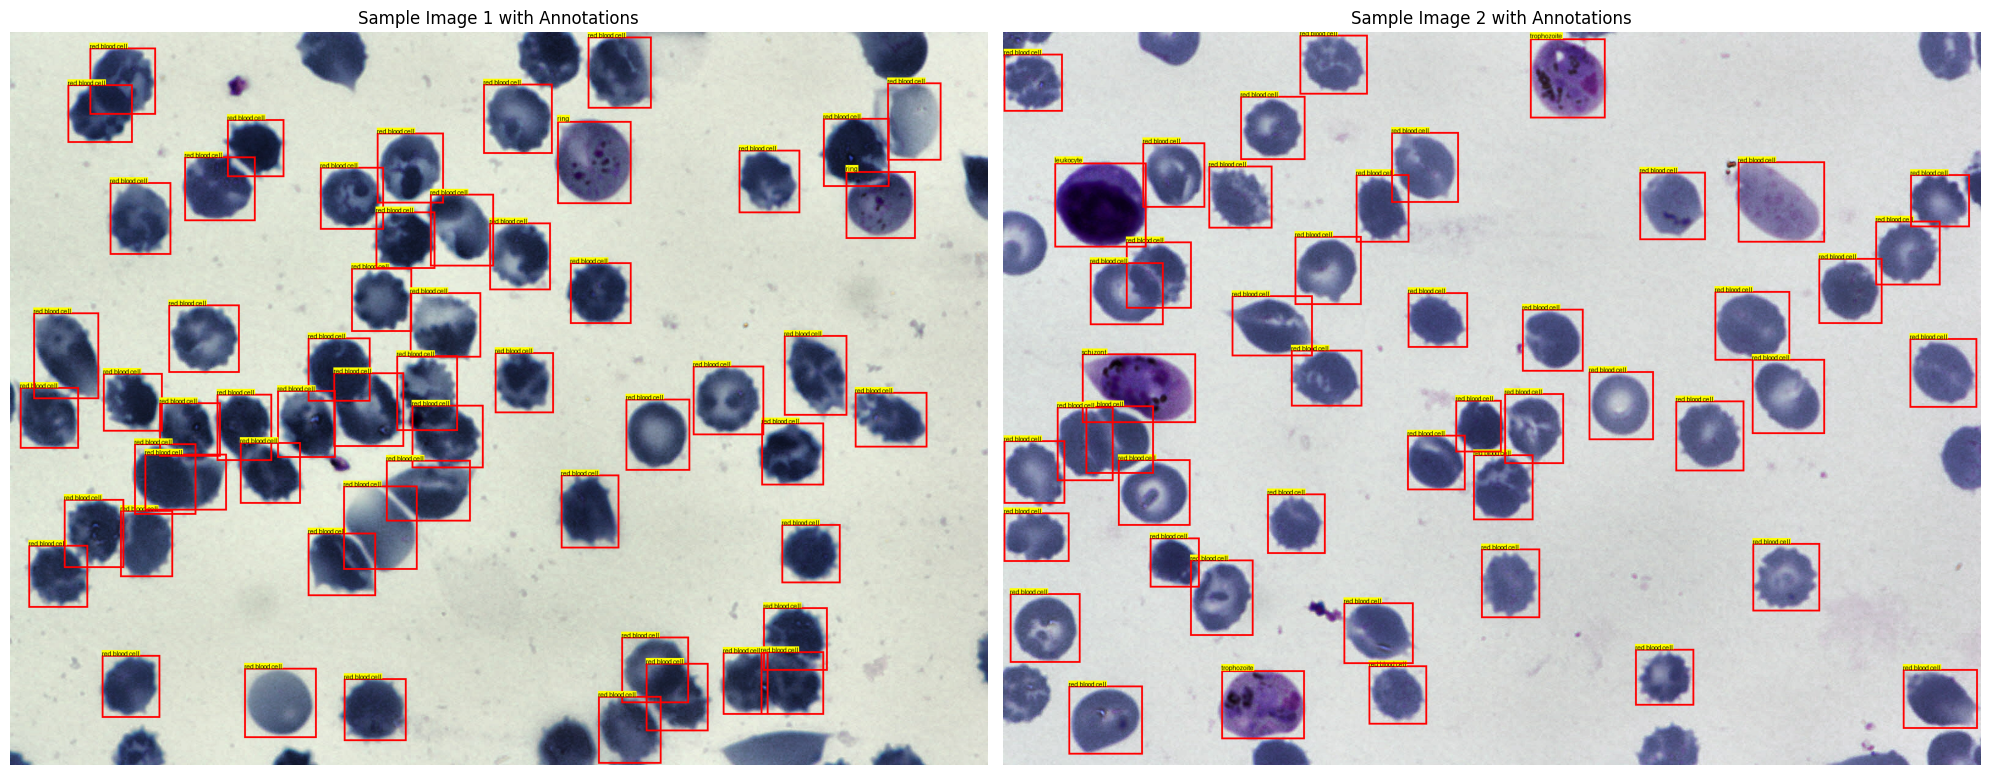

In [182]:
# Load the training data to get image paths and annotations
train_json_path = 'malaria_data/malaria/labels/train.json' # Updated path
try:
    with open(train_json_path, 'r') as f:
        train_data = json.load(f)
except FileNotFoundError:
    print(f"Error: The file {train_json_path} was not found.")
    train_data = []
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {train_json_path}. Please check the file format.")
    train_data = []
except Exception as e:
    print(f"An error occurred: {e}")
    train_data = []


# Select 2 random entries from the training data
num_images_to_display = 2
if len(train_data) >= num_images_to_display:
    sample_entries = random.sample(train_data, num_images_to_display)
else:
    sample_entries = train_data
    num_images_to_display = len(sample_entries)


image_dir = 'malaria_data/malaria/images/train' # Corrected base directory for training images

plt.figure(figsize=(20,20))

for i, entry in enumerate(sample_entries):
    image_pathname = os.path.basename(entry['image']['pathname']) # Get just the filename
    # Construct the full image path by joining the corrected base directory and the filename
    image_path = os.path.join(image_dir, image_pathname)


    try:
        img = Image.open(image_path).convert("RGB") # Convert to RGB to ensure compatibility with drawing
        draw = ImageDraw.Draw(img)

        # Draw bounding boxes and labels
        for obj in entry['objects']:
            bbox = obj['bounding_box']
            category = obj['category']
            # The JSON uses 'c' for column (x) and 'r' for row (y)
            # PIL's bounding box is (x_min, y_min, x_max, y_max)
            x_min = bbox['minimum']['c']
            y_min = bbox['minimum']['r']
            x_max = bbox['maximum']['c']
            y_max = bbox['maximum']['r']

            # Draw rectangle
            draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=3)

            # Draw label background
            text_color = "black"
            box_color = "yellow"
            try:
                # Attempt to use a common font
                font = ImageFont.truetype("arial.ttf", 20)
            except IOError:
                # Fallback to default PIL font if arial.ttf is not available
                font = ImageFont.load_default()


            # Use textbbox instead of textsize
            text_bbox = draw.textbbox((x_min, y_min), category, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            text_box_coords = [(x_min, y_min - text_height), (x_min + text_width, y_min)]
            draw.rectangle(text_box_coords, fill=box_color)

            # Draw label text
            draw.text((x_min, y_min - text_height), category, fill=text_color, font=font)


        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(img)
        plt.title(f"Sample Image {i+1} with Annotations")
        plt.axis('off') # Hide axes for cleaner image display

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"An error occurred while processing image {image_path}: {e}")

plt.tight_layout()
plt.show()

### **1.5.5 Check for mislabelled images**

In [183]:
# Collect all category names
all_categories = [obj["category"] for img in train_data for obj in img["objects"]]
unique_categories = sorted(set(all_categories))

print("Unique labels found in train dataset:", unique_categories)

# If you expect only these categories:
expected_labels = {'difficult','gametocyte','leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite'}

# Check for unexpected labels
unexpected = [c for c in unique_categories if c not in expected_labels]
if unexpected:
    print("Found unexpected or misspelled categories:", unexpected)
else:
    print("All labels match expected categories.")

Unique labels found in train dataset: ['difficult', 'gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']
All labels match expected categories.


In [184]:
# Collect all category names
all_categories = [obj["category"] for img in test_data for obj in img["objects"]]
unique_categories = sorted(set(all_categories))

print("Unique labels found in test dataset:", unique_categories)

# If you expect only these categories:
expected_labels = {'difficult','gametocyte','leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite'}

# Check for unexpected labels
unexpected = [c for c in unique_categories if c not in expected_labels]
if unexpected:
    print("Found unexpected or misspelled categories:", unexpected)
else:
    print("All labels match expected categories.")

Unique labels found in test dataset: ['difficult', 'gametocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']
All labels match expected categories.


### **1.5.6 Check for any bounding box issues**

In [185]:
bad_boxes = []

for img_data in test_data:
    img_name = os.path.basename(img_data["image"]["pathname"])
    w = img_data["image"]["shape"]["c"]
    h = img_data["image"]["shape"]["r"]
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        xmin, ymin = box["minimum"]["c"], box["minimum"]["r"]
        xmax, ymax = box["maximum"]["c"], box["maximum"]["r"]
        if xmin >= xmax or ymin >= ymax:
            bad_boxes.append((img_name, "zero or negative box size"))
        elif xmin < 0 or ymin < 0 or xmax > w or ymax > h:
            bad_boxes.append((img_name, "box outside image bounds"))

print(f" Found {len(bad_boxes)} bounding box issues in test data.")
if bad_boxes:
    for i, (img, issue) in enumerate(bad_boxes[:10]):
        print(f"{i+1}. {img} → {issue}")

 Found 0 bounding box issues in test data.


In [186]:
bad_boxes = []

for img_data in train_data:
    img_name = os.path.basename(img_data["image"]["pathname"])
    w = img_data["image"]["shape"]["c"]
    h = img_data["image"]["shape"]["r"]
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        xmin, ymin = box["minimum"]["c"], box["minimum"]["r"]
        xmax, ymax = box["maximum"]["c"], box["maximum"]["r"]
        if xmin >= xmax or ymin >= ymax:
            bad_boxes.append((img_name, "zero or negative box size"))
        elif xmin < 0 or ymin < 0 or xmax > w or ymax > h:
            bad_boxes.append((img_name, "box outside image bounds"))

print(f" Found {len(bad_boxes)} bounding box issues in train data.")
if bad_boxes:
    for i, (img, issue) in enumerate(bad_boxes[:10]):
        print(f"{i+1}. {img} → {issue}")

 Found 0 bounding box issues in train data.


### **1.5.7 Detect duplicate boxes on the same objec**t

In [187]:
duplicates = []
for img_data in train_data:
    seen = set()
    img_name = os.path.basename(img_data["image"]["pathname"])
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        coords = (
            box["minimum"]["c"], box["minimum"]["r"],
            box["maximum"]["c"], box["maximum"]["r"]
        )
        if coords in seen:
            duplicates.append(img_name)
        else:
            seen.add(coords)

duplicates = list(set(duplicates))
print(f" Found {len(duplicates)} images with duplicate bounding boxes in train subset.")
if duplicates:
    print("Examples:", duplicates[:10])

 Found 0 images with duplicate bounding boxes in train subset.


In [188]:
duplicates = []
for img_data in test_data:
    seen = set()
    img_name = os.path.basename(img_data["image"]["pathname"])
    for obj in img_data["objects"]:
        box = obj["bounding_box"]
        coords = (
            box["minimum"]["c"], box["minimum"]["r"],
            box["maximum"]["c"], box["maximum"]["r"]
        )
        if coords in seen:
            duplicates.append(img_name)
        else:
            seen.add(coords)

duplicates = list(set(duplicates))
print(f" Found {len(duplicates)} images with duplicate bounding boxes in test subset.")
if duplicates:
    print("Examples:", duplicates[:10])

 Found 0 images with duplicate bounding boxes in test subset.


### **1.5.8 Check for class imbalance**

Object category distribution in training data:
Counter({'red blood cell': 77420,
         'trophozoite': 1473,
         'difficult': 441,
         'ring': 353,
         'schizont': 179,
         'gametocyte': 144,
         'leukocyte': 103})


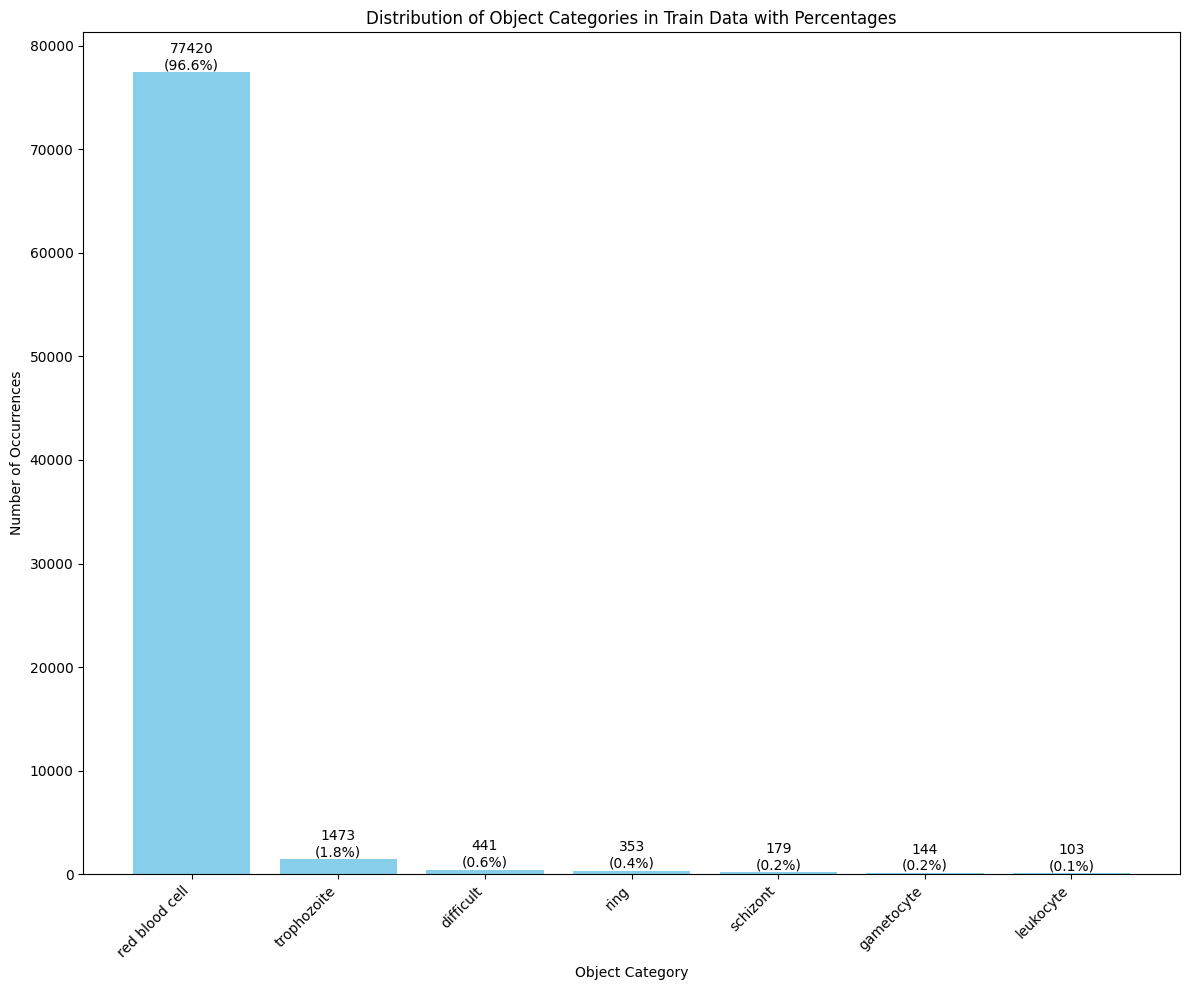

In [189]:
# check distribution of classes in train images
# Assuming train_data is already available from a previous cell's execution
# If not, load it first
if 'train_data' not in locals():
    train_json_path = 'malaria_data/malaria/labels/train.json' # Updated path
    try:
        with open(train_json_path, 'r') as f:
            train_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file {train_json_path} was not found. Cannot analyze class distribution.")
        train_data = []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {train_json_path}. Cannot analyze class distribution.")
        train_data = []
    except Exception as e:
        print(f"An error occurred: {e}. Cannot analyze class distribution.")
        train_data = []


# Collect all object categories
categories_list = []
for entry in train_data:
    for obj in entry['objects']:
        categories_list.append(obj['category'])

# Count the occurrences of each category
category_counts = Counter(categories_list)

print("Object category distribution in training data:")
pprint(category_counts)

# Sort categories and counts in descending order of counts
sorted_counts = dict(category_counts.most_common())
categories = list(sorted_counts.keys())
counts = list(sorted_counts.values())

# Calculate total count for percentages
total_count = sum(counts)

# Create a bar plot
plt.figure(figsize=(12, 10))
bars = plt.bar(categories, counts, color='skyblue')
plt.xlabel("Object Category")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Object Categories in Train Data with Percentages")
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

# Add text annotations for counts and percentages
for bar in bars:
    yval = bar.get_height()
    percentage = (yval / total_count) * 100 if total_count > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2, yval,
             f'{yval}\n({percentage:.1f}%)',
             va='bottom', ha='center', rotation=0, fontsize=10) # Adjust va, ha, rotation, and fontsize as needed

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

**Red blood cells** are the most frequent category, making up a very large percentage of the total objects.

The next most frequent category is **trophozoite**, but its count is significantly lower than that of red blood cells.

The remaining categories, including difficult, ring, schizont, gametocyte, and leukocyte, have much lower counts compared to red blood cells and trophozoites.

There is **imbalance in the dataset** with a disproportionately high number of red blood cells compared to the other categories, especially the different stages of the malaria parasite (trophozoite, ring, schizont, gametocyte). Therefore this imbalance will have to be handled before model training to ensure the model can effectively detect the less frequent classes.

A combination of data augmentation and use of weighted loss function or Focal Loss will likely be effective strategies.

Object category distribution in testing data:
Counter({'red blood cell': 5614,
         'ring': 169,
         'trophozoite': 111,
         'gametocyte': 12,
         'schizont': 11,
         'difficult': 5})


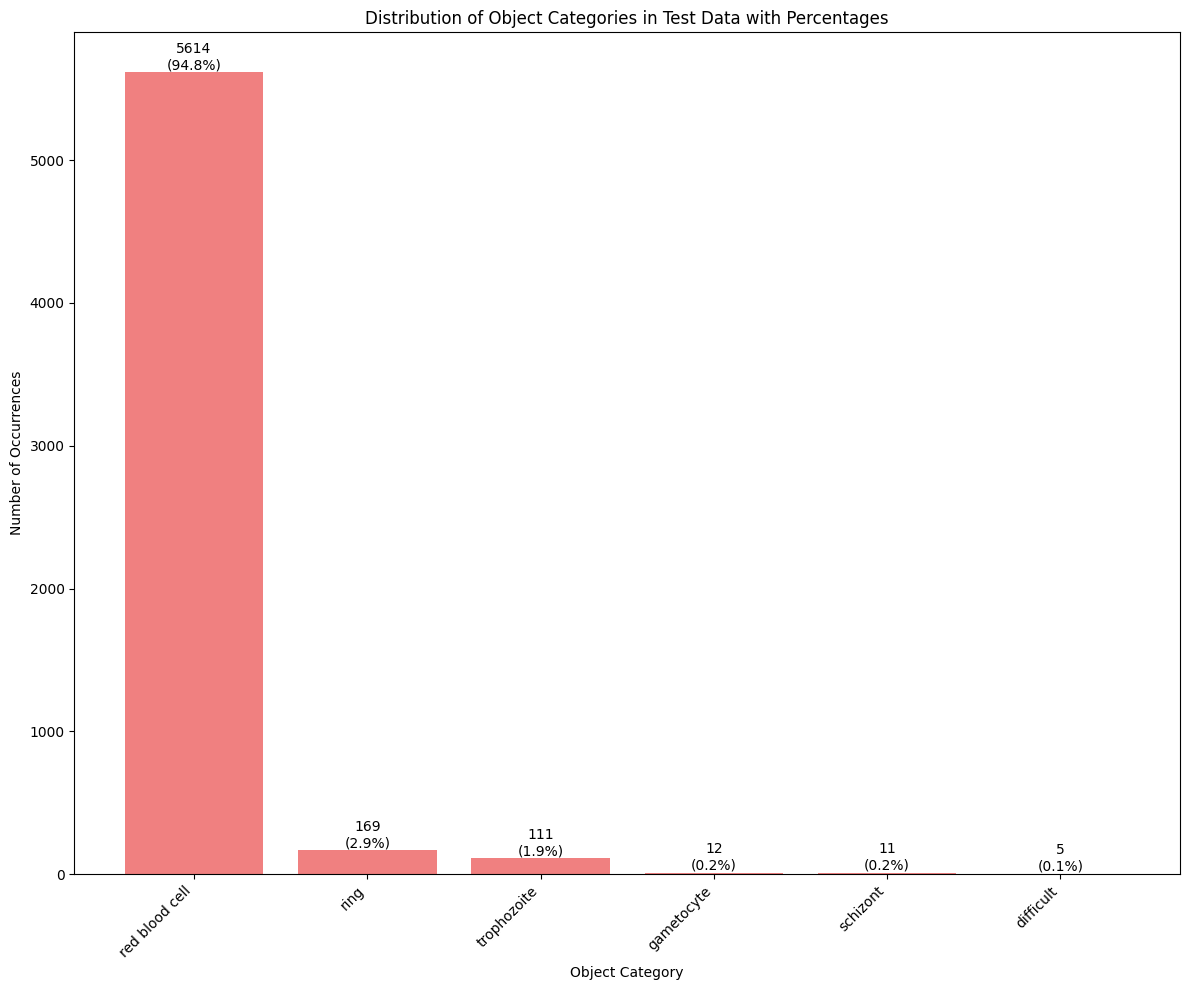

In [190]:
# Assuming test_data is already available from a previous cell's execution
# If not, load it first
if 'test_data' not in locals():
    test_json_path = 'malaria_data/malaria/labels/test.json' # Updated path
    try:
        with open(test_json_path, 'r') as f:
            test_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: The file {test_json_path} was not found. Cannot analyze class distribution.")
        test_data = []
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {test_json_path}. Cannot analyze class distribution.")
        test_data = []
    except Exception as e:
        print(f"An error occurred: {e}. Cannot analyze class distribution.")
        test_data = []

# Collect all object categories
categories_list = []
for entry in test_data:
    for obj in entry['objects']:
        categories_list.append(obj['category'])

# Count the occurrences of each category
category_counts = Counter(categories_list)

print("Object category distribution in testing data:")
pprint(category_counts)

# Optional: Create a bar plot for test data distribution
if category_counts:
    # Sort categories and counts in descending order of counts
    sorted_counts = dict(category_counts.most_common())
    categories = list(sorted_counts.keys())
    counts = list(sorted_counts.values())

    # Calculate total count for percentages
    total_count = sum(counts)

    plt.figure(figsize=(12, 10))
    bars = plt.bar(categories, counts, color='lightcoral')
    plt.xlabel("Object Category")
    plt.ylabel("Number of Occurrences")
    plt.title("Distribution of Object Categories in Test Data with Percentages")
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

    # Add text annotations for counts and percentages
    for bar in bars:
        yval = bar.get_height()
        percentage = (yval / total_count) * 100 if total_count > 0 else 0
        plt.text(bar.get_x() + bar.get_width()/2, yval,
                 f'{yval}\n({percentage:.1f}%)',
                 va='bottom', ha='center', rotation=0, fontsize=10) # Adjust va, ha, rotation, and fontsize as needed

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("No object categories found in test data to plot.")

The plot for the test data distribution, similar to the training data, shows a significant class imbalance.

Red blood cells are the most numerous category by a large margin, similar to the training data.
The counts for the other categories (ring, trophozoite, gametocyte, schizont, and difficult) are considerably lower than that of red blood cells.
The malaria parasite stages (ring, trophozoite, gametocyte, and schizont) are minority classes in the test set as well.
The category 'leukocyte' is present in the training data but appears to be absent in the test data, or its count is very low (it's not shown in the plotted categories, likely due to having 0 or very few instances).

## **1.6 Data preprocessing**

### **1.6.1 Augmentations**

Categories of Augmentations that will be done

**Geometric Transformations**:change position or orientation of objects within the image and corresponding adjustments to bounding box annotations will be done.
*   Vertical Flipping
*   Horizontal Flipping
*   Rotation
*   Scaling (Zooming)
*   Translation (Shifting)
*   Shearing
*   Cropping (Random or based on objects)

**Color/Appearance Transformations**: alter the visual appearance of the image without changing the object positions. Bounding boxes remain unchanged.
*   Adjust Brightness
*   Adjust Contrast
*   Adjust Saturation
*   Adjust Hue

**Noise and Artifacts**: add simulated real-world imperfections. Bounding boxes remain unchanged.
*   Adding Noise (e.g., Gaussian)
*   Adding Blur (e.g., Gaussian)
*   Random Erasing / Cutout

**Multi-Image Transformations**: These techniques combine information from multiple images.

*   Mixup
*   Mosaic


### Function for horizontal flip transformation

In [191]:
# # --- Define PIL Augmentation Functions ---
# # Including functions for geometric, color, and noise/artifact transformations

# def horizontal_flip_pil(image, annotations):
#     """
#     Applies horizontal flip to a PIL image and adjusts bounding box annotations.
#     """
#     flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
#     img_width, img_height = image.size

#     flipped_annotations = []
#     for obj in annotations:
#         bbox = obj['bounding_box']
#         category = obj['category']
#         x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
#         x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

#         new_x_min = img_width - x_max
#         new_x_max = img_width - x_min
#         new_y_min = y_min
#         new_y_max = y_max

#         # Ensure coordinates are within new image bounds (clipping)
#         new_x_min = max(0, new_x_min)
#         new_y_min = max(0, new_y_min)
#         new_x_max = min(img_width, new_x_max)
#         new_y_max = min(img_height, new_y_max)

#         if new_x_max > new_x_min and new_y_max > new_y_min:
#              flipped_annotations.append({
#                 'bounding_box': {
#                     'minimum': {'c': new_x_min, 'r': new_y_min},
#                     'maximum': {'c': new_x_max, 'r': new_y_max}
#                 },
#                 'category': category
#             })

#     return flipped_image, flipped_annotations

### function for vertical flip trasnsformation

In [192]:
# def vertical_flip_pil(image, annotations):
#     """
#     Applies vertical flip to a PIL image and adjusts bounding box annotations.
#     """
#     flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)
#     img_width, img_height = image.size

#     flipped_annotations = []
#     for obj in annotations:
#         bbox = obj['bounding_box']
#         category = obj['category']
#         x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
#         x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

#         new_x_min = x_min
#         new_x_max = x_max
#         new_y_min = img_height - y_max
#         new_y_max = img_height - y_min

#         # Ensure coordinates are within new image bounds (clipping)
#         new_x_min = max(0, new_x_min)
#         new_y_min = max(0, new_y_min)
#         new_x_max = min(img_width, new_x_max)
#         new_y_max = min(img_height, new_y_max)


#         if new_x_max > new_x_min and new_y_max > new_y_min:
#              flipped_annotations.append({
#                 'bounding_box': {
#                     'minimum': {'c': new_x_min, 'r': new_y_min},
#                     'maximum': {'c': new_x_max, 'r': new_y_max}
#                 },
#                 'category': category
#             })

#     return flipped_image, flipped_annotations

### function for crop transformation

In [193]:
# def object_based_crop_image_pil(image, annotations, min_object_coverage=0.9, min_crop_scale=0.8):
#     """
#     Applies cropping to a PIL image, attempting to keep objects within the crop
#     by selecting a crop region based on object locations.

#     Args:
#         image: PIL Image object.
#         annotations: List of object annotations.
#         min_object_coverage: Minimum fraction of an object's area that must be within the crop
#                              for the object to be included in the cropped annotations.
#         min_crop_scale: Minimum scale of the cropped region relative to the original image size.

#     Returns:
#         A tuple containing the cropped PIL Image and the updated annotations,
#         or (original_image, []) if a suitable crop could not be found.
#     """
#     img_width, img_height = image.size

#     if not annotations:
#         print("No objects found in annotations. Returning original image.")
#         return image, []

#     # Select a random object to center the crop around (or influence the crop area)
#     # A more sophisticated approach might consider all objects or minority objects
#     target_obj = random.choice(annotations)
#     target_bbox = target_obj['bounding_box']
#     target_xmin, target_ymin = target_bbox['minimum']['c'], target_bbox['minimum']['r']
#     target_xmax, target_ymax = target_bbox['maximum']['c'], target_bbox['maximum']['r']
#     target_center_x = (target_xmin + target_xmax) / 2
#     target_center_y = (target_ymin + target_ymax) / 2


#     # Attempt to find a valid crop region multiple times
#     for _ in range(20): # Try up to 20 times to find a crop with objects
#         # Determine crop size based on min_crop_scale
#         crop_width = int(img_width * random.uniform(min_crop_scale, 1.0))
#         crop_height = int(img_height * random.uniform(min_crop_scale, 1.0))

#         # Determine crop top-left corner, trying to center around the target object
#         # Ensure the crop stays within image bounds
#         x_offset_max = min(img_width - crop_width, int(target_center_x - crop_width / 2))
#         x_offset_min = max(0, int(target_center_x - crop_width / 2))
#         x_offset = random.randint(x_offset_min, x_offset_max) if x_offset_min <= x_offset_max else x_offset_min


#         y_offset_max = min(img_height - crop_height, int(target_center_y - crop_height / 2))
#         y_offset_min = max(0, int(target_center_y - crop_height / 2))
#         y_offset = random.randint(y_offset_min, y_offset_max) if y_offset_min <= y_offset_max else y_offset_min


#         # Define crop bounding box (x1, y1, x2, y2)
#         crop_bbox = (x_offset, y_offset, x_offset + crop_width, y_offset + crop_height)

#         cropped_annotations = []
#         # Check which objects are within the cropped area and adjust their bounding boxes
#         for obj in annotations:
#             bbox = obj['bounding_box']
#             category = obj['category']
#             xmin, ymin = bbox['minimum']['c'], bbox['minimum']['r']
#             xmax, ymax = bbox['maximum']['c'], bbox['maximum']['r']

#             # Get intersection of object bbox and crop bbox
#             intersect_xmin = max(xmin, crop_bbox[0])
#             intersect_ymin = max(ymin, crop_bbox[1])
#             intersect_xmax = min(xmax, crop_bbox[2])
#             intersect_ymax = min(ymax, crop_bbox[3])

#             # Calculate intersection area
#             intersect_width = max(0, intersect_xmax - intersect_xmin)
#             intersect_height = max(0, intersect_ymax - intersect_ymin)
#             intersect_area = intersect_width * intersect_height

#             # Calculate object area
#             object_width = xmax - xmin
#             object_height = ymax - ymin
#             object_area = object_width * object_height

#             # Check if object is sufficiently covered by the crop and if intersection is valid
#             if object_area > 0 and intersect_area > 0 and intersect_area / object_area >= min_object_coverage:
#                 # Adjust bounding box coordinates relative to the cropped image
#                 new_xmin = intersect_xmin - x_offset
#                 new_ymin = intersect_ymin - y_offset
#                 new_xmax = intersect_xmax - x_offset
#                 new_ymax = intersect_ymax - y_offset

#                 # Ensure coordinates are within the new cropped image bounds (0 to crop_width/height)
#                 new_xmin = max(0, new_xmin)
#                 new_ymin = max(0, new_ymin)
#                 new_xmax = min(crop_width, new_xmax)
#                 new_ymax = min(crop_height, new_ymax)

#                 # Add the object with its new bounding box
#                 # Only add if the adjusted bounding box is still valid (positive size)
#                 if new_xmax > new_xmin and new_ymax > new_ymin:
#                      cropped_annotations.append({
#                         'bounding_box': {
#                             'minimum': {'c': new_xmin, 'r': new_ymin},
#                             'maximum': {'c': new_xmax, 'r': new_ymax}
#                         },
#                         'category': category
#                     })

#         # If at least one object remains after cropping, this is a valid crop
#         if cropped_annotations:
#             # Crop the image
#             cropped_image = image.crop(crop_bbox)
#             return cropped_image, cropped_annotations

#     # If no suitable crop was found after multiple attempts
#     print("Could not find a suitable crop that retains objects after multiple attempts. Returning original image and empty annotations.")
#     return image, [] # Return original image and empty list as a fallback

# # Example usage:
# # image = Image.open("your_image.png").convert("RGB")
# # annotations = [...]
# # cropped_image, cropped_annotations = object_based_crop_image_pil(image, annotations, min_object_coverage=0.8)
# # if cropped_image:
# #     # Display or save the cropped image and annotations
# #     pass

### function for rotation transformation

In [194]:
# def rotate_image_pil(image, annotations, angle):
#     """
#     Rotates a PIL image by a given angle and adjusts bounding box annotations
#     by transforming bounding box corners.
#     """
#     img_width, img_height = image.size

#     rotated_image = image.rotate(angle, expand=True, resample=Image.Resampling.BICUBIC)
#     new_width, new_height = rotated_image.size

#     original_center_x, original_center_y = img_width / 2, img_height / 2
#     new_center_x, new_center_y = new_width / 2, new_height / 2

#     rotated_annotations = []
#     for obj in annotations:
#         bbox = obj['bounding_box']
#         category = obj['category']
#         x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
#         x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

#         original_corners = np.array([
#             [x_min, y_min],
#             [x_max, y_min],
#             [x_min, y_max],
#             [x_max, y_max]
#         ])

#         translated_corners = original_corners - np.array([original_center_x, original_center_y])

#         angle_rad = np.deg2rad(angle)
#         rotation_matrix = np.array([
#             [np.cos(angle_rad), -np.sin(angle_rad)],
#             [np.sin(angle_rad), np.cos(angle_rad)]
#         ])
#         rotated_translated_corners = np.dot(translated_corners, rotation_matrix.T)

#         new_corners = rotated_translated_corners + np.array([new_center_x, new_center_y])

#         new_x_min = int(np.min(new_corners[:, 0]))
#         new_y_min = int(np.min(new_corners[:, 1]))
#         new_x_max = int(np.max(new_corners[:, 0]))
#         new_y_max = int(np.max(new_corners[:, 1]))

#         new_x_min = max(0, new_x_min)
#         new_y_min = max(0, new_y_min)
#         new_x_max = min(new_width, new_x_max)
#         new_y_max = min(new_height, new_y_height)

#         if new_x_max > new_x_min and new_y_max > new_y_min:
#              rotated_annotations.append({
#                 'bounding_box': {
#                     'minimum': {'c': new_x_min, 'r': new_y_min},
#                     'maximum': {'c': new_x_max, 'r': new_y_max}
#                 },
#                 'category': category
#             })

#     return rotated_image, rotated_annotations

### function for scale transformation

In [195]:
# def scale_image_pil(image, annotations, scale_factor):
#     """
#     Scales a PIL image and adjusts bounding box annotations.
#     """
#     img_width, img_height = image.size
#     new_width = int(img_width * scale_factor)
#     new_height = int(img_height * scale_factor)

#     scaled_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

#     scaled_annotations = []
#     for obj in annotations:
#         bbox = obj['bounding_box']
#         category = obj['category']
#         x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
#         x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

#         new_x_min = int(x_min * scale_factor)
#         new_y_min = int(y_min * scale_factor)
#         new_x_max = int(x_max * scale_factor)
#         new_y_max = int(y_max * scale_factor)

#         new_x_min = max(0, new_x_min)
#         new_y_min = max(0, new_y_min)
#         new_x_max = min(new_width, new_x_max)
#         new_y_max = min(new_height, new_y_max)

#         if new_x_max > new_x_min and new_y_max > new_y_min:
#             scaled_annotations.append({
#                 'bounding_box': {
#                     'minimum': {'c': new_x_min, 'r': new_y_min},
#                     'maximum': {'c': new_x_max, 'r': new_y_max}
#                 },
#                 'category': category
#             })

#     return scaled_image, scaled_annotations

### function for translate transformation

In [196]:
# def translate_image_pil(image, annotations, x_shift, y_shift):
#     """
#     Translates (shifts) a PIL image and adjusts bounding box annotations.
#     """
#     img_width, img_height = image.size

#     translated_image = image.transform(
#         image.size,
#         Image.Transform.AFFINE,
#         (1, 0, x_shift, 0, 1, y_shift)
#     )

#     translated_annotations = []
#     for obj in annotations:
#         bbox = obj['bounding_box']
#         category = obj['category']
#         x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
#         x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

#         new_x_min = x_min + x_shift
#         new_y_min = y_min + y_shift
#         new_x_max = x_max + x_shift
#         new_y_max = y_max + y_shift

#         new_x_min = max(0, new_x_min)
#         new_y_min = max(0, new_y_min)
#         new_x_max = min(img_width, new_x_max)
#         new_y_max = min(img_height, new_y_max)

#         if new_x_max > new_x_min and new_y_max > new_y_min:
#             translated_annotations.append({
#                 'bounding_box': {
#                     'minimum': {'c': new_x_min, 'r': new_y_min},
#                     'maximum': {'c': new_x_max, 'r': new_y_max}
#                 },
#                 'category': category
#             })

#     return translated_image, translated_annotations

### funtion for shearing transformation

In [197]:
# def shear_image_pil(image, annotations, shear_factor_x=0, shear_factor_y=0):
#     """
#     Applies shearing to a PIL image and attempts to adjust bounding box annotations
#     by transforming bounding box corners. Note: This is complex and may not be
#     perfect for all cases with axis-aligned boxes.
#     """
#     img_width, img_height = image.size

#     # Simplified shear transform applied to image, assuming shear around origin
#     # For robust shearing with bounding boxes, dedicated libraries are recommended.
#     # This implementation transforms corners and finds the enclosing axis-aligned box.

#     # Apply shear transform to image corners to find new image size
#     original_corners_img = np.array([
#         [0, 0], [img_width, 0], [0, img_height], [img_width, img_height]
#     ])

#     sheared_img_corners = np.array([
#         [c[0] + shear_factor_x * c[1], c[1] + shear_factor_y * c[0]] for c in original_corners_img
#     ])

#     min_x_img, min_y_img = np.min(sheared_img_corners, axis=0)
#     max_x_img, max_y_img = np.max(sheared_img_corners, axis=0)

#     new_width = int(max_x_img - min_x_img)
#     new_height = int(max_y_img - min_y_img)

#     # Apply affine shear transform to the image
#     affine_transform_tuple_translated = (1, shear_factor_x, -min_x_img + shear_factor_x * (-min_y_img),
#                                          shear_factor_y, 1, -min_y_img + shear_factor_y * (-min_x_img))

#     sheared_image = image.transform(
#         (new_width, new_height),
#         Image.Transform.AFFINE,
#         affine_transform_tuple_translated,
#         resample=Image.Resampling.BICUBIC
#     )

#     sheared_annotations = []
#     for obj in annotations:
#         bbox = obj['bounding_box']
#         category = obj['category']
#         x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
#         x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

#         original_corners = np.array([
#             [x_min, y_min],
#             [x_max, y_min],
#             [x_min, y_max],
#             [x_max, y_max]
#         ])

#         sheared_corners = np.array([
#             [c[0] + shear_factor_x * c[1], c[1] + shear_factor_y * c[0]] for c in original_corners
#         ])

#         translated_sheared_corners = sheared_corners - np.array([min_x_img, min_y_img])

#         new_x_min = int(np.min(translated_sheared_corners[:, 0]))
#         new_y_min = int(np.min(translated_sheared_corners[:, 1]))
#         new_x_max = int(np.max(translated_sheared_corners[:, 0]))
#         new_y_max = int(np.max(translated_sheared_corners[:, 1]))

#         new_x_min = max(0, new_x_min)
#         new_y_min = max(0, new_y_min)
#         new_x_max = min(new_width, new_x_max)
#         new_y_max = min(new_height, new_y_height)

#         if new_x_max > new_x_min and new_y_max > new_y_min:
#              sheared_annotations.append({
#                 'bounding_box': {
#                     'minimum': {'c': new_x_min, 'r': new_y_min},
#                     'maximum': {'c': new_x_max, 'r': new_y_max}
#                 },
#                 'category': category
#             })

#     return sheared_image, sheared_annotations

### function for color transformation

In [198]:
# def color_transformations_pil(image, annotations, brightness_factor=(0.8, 1.2), contrast_factor=(0.8, 1.2), saturation_factor=(0.8, 1.2)):
#     """
#     Applies random color transformations (brightness, contrast, saturation) to a PIL image.
#     """
#     augmented_image = image.copy()

#     brightness_enhancer = ImageEnhance.Brightness(augmented_image)
#     augmented_image = brightness_enhancer.enhance(random.uniform(brightness_factor[0], brightness_factor[1]))

#     contrast_enhancer = ImageEnhance.Contrast(augmented_image)
#     augmented_image = contrast_enhancer.enhance(random.uniform(contrast_factor[0], contrast_factor[1]))

#     saturation_enhancer = ImageEnhance.Color(augmented_image)
#     augmented_image = saturation_enhancer.enhance(random.uniform(saturation_factor[0], saturation_factor[1]))

#     return augmented_image, annotations

### function for noise, blur and erase transformations

In [199]:
# def noise_blur_erase_pil(image, annotations, noise_factor=0.1, blur_radius=1, erase_probability=0.2, erase_size=(0.02, 0.2)):
#     """
#     Applies noise, blur, and random erasing to a PIL image.
#     """
#     augmented_image = image.copy()

#     # Add Gaussian Noise
#     # Needs OpenCV
#     # try:
#     #     import cv2
#     #     img_np = np.array(augmented_image)
#     #     mean = 0
#     #     std_dev = noise_factor * 255
#     #     noise = np.random.normal(mean, std_dev, img_np.shape).astype('uint8')
#     #     img_np = cv2.add(img_np, noise)
#     #     augmented_image = Image.fromarray(img_np)
#     # except ImportError:
#     #      print("Warning: OpenCV not found. Skipping noise addition.")
#     # except Exception as e:
#     #     print(f"Error adding noise: {e}. Skipping noise addition.")

#     # Skipping noise for now as it requires OpenCV

#     # Add Gaussian Blur
#     if blur_radius > 0:
#         augmented_image = augmented_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))

#     # Random Erasing / Cutout
#     img_width, img_height = augmented_image.size
#     erase_area_min = erase_size[0] * img_width * img_height
#     erase_area_max = erase_size[1] * img_width * img_height

#     if random.random() < erase_probability:
#         for _ in range(10):
#             erase_width = random.randint(10, int(img_width * np.sqrt(erase_size[1])))
#             erase_height = random.randint(10, int(img_height * np.sqrt(erase_size[1])))

#             erase_x = random.randint(0, img_width - erase_width)
#             erase_y = random.randint(0, img_height - erase_height)

#             current_erase_area = erase_width * erase_height
#             if current_erase_area >= erase_area_min and current_erase_area <= erase_area_max:
#                 erase_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
#                 draw = ImageDraw.Draw(augmented_image)
#                 draw.rectangle([(erase_x, erase_y), (erase_x + erase_width, erase_y + erase_height)], fill=erase_color)
#                 break

#     return augmented_image, annotations

### function for object based cropping transformation

In [200]:
# def object_based_crop_image_pil(image, annotations, min_object_coverage=0.9, min_crop_scale=0.8):
#     """
#     Applies cropping to a PIL image, attempting to keep objects within the crop
#     by selecting a crop region based on object locations.
#     """
#     img_width, img_height = image.size

#     if not annotations:
#         # print("No objects found in annotations. Returning original image.")
#         return image, []

#     # Select a random object to center the crop around (or influence the crop area)
#     target_obj = random.choice(annotations)
#     target_bbox = target_obj['bounding_box']
#     target_xmin, target_ymin = target_bbox['minimum']['c'], target_bbox['minimum']['r']
#     target_xmax, target_ymax = target_bbox['maximum']['c'], target_bbox['maximum']['r']
#     target_center_x = (target_xmin + target_xmax) / 2
#     target_center_y = (target_ymin + target_ymax) / 2


#     for _ in range(20): # Try up to 20 times to find a crop with objects
#         crop_width = int(img_width * random.uniform(min_crop_scale, 1.0))
#         crop_height = int(img_height * random.uniform(min_crop_scale, 1.0))

#         x_offset_max = min(img_width - crop_width, int(target_center_x - crop_width / 2))
#         x_offset_min = max(0, int(target_center_x - crop_width / 2))
#         x_offset = random.randint(x_offset_min, x_offset_max) if x_offset_min <= x_offset_max else x_offset_min


#         y_offset_max = min(img_height - crop_height, int(target_center_y - crop_height / 2))
#         y_offset_min = max(0, int(target_center_y - crop_height / 2))
#         y_offset = random.randint(y_offset_min, y_offset_max) if y_offset_min <= y_offset_max else y_offset_min


#         crop_bbox = (x_offset, y_offset, x_offset + crop_width, y_offset + crop_height)

#         cropped_annotations = []
#         for obj in annotations:
#             bbox = obj['bounding_box']
#             category = obj['category']
#             xmin, ymin = bbox['minimum']['c'], bbox['minimum']['r']
#             xmax, ymax = bbox['maximum']['c'], bbox['maximum']['r']

#             intersect_xmin = max(xmin, crop_bbox[0])
#             intersect_ymin = max(ymin, crop_bbox[1])
#             intersect_xmax = min(xmax, crop_bbox[2])
#             intersect_ymax = min(ymax, crop_bbox[3])

#             intersect_width = max(0, intersect_xmax - intersect_xmin)
#             intersect_height = max(0, intersect_ymax - intersect_ymin)
#             intersect_area = intersect_width * intersect_height

#             object_width = xmax - xmin
#             object_height = ymax - ymin
#             object_area = object_width * object_height

#             if object_area > 0 and intersect_area > 0 and intersect_area / object_area >= min_object_coverage:
#                 new_xmin = intersect_xmin - x_offset
#                 new_ymin = intersect_ymin - y_offset
#                 new_xmax = intersect_xmax - x_offset
#                 new_ymax = intersect_ymax - y_offset

#                 new_xmin = max(0, new_xmin)
#                 new_ymin = max(0, new_ymin)
#                 new_xmax = min(crop_width, new_xmax)
#                 new_ymax = min(crop_height, new_ymax)

#                 if new_xmax > new_xmin and new_ymax > new_ymin:
#                      cropped_annotations.append({
#                         'bounding_box': {
#                             'minimum': {'c': new_xmin, 'r': new_ymin},
#                             'maximum': {'c': new_xmax, 'r': new_ymax}
#                         },
#                         'category': category
#                     })

#         if cropped_annotations:
#             cropped_image = image.crop(crop_bbox)
#             return cropped_image, cropped_annotations

#     # print("Could not find a suitable crop that retains objects after multiple attempts. Returning original image and empty annotations.")
#     return image, []

These augmentations will target minority classes and also be applied differentially to the minority classes versus majority class.

### **Target augmentation strategy**

### implementation of augmentation pipeline

In [ ]:
# Implement the refined augmentation pipeline

# Assuming train_data is available

# --- Define minority classes ---
minority_classes = ['trophozoite', 'difficult', 'ring', 'schizont', 'gametocyte', 'leukocyte']
print("Minority classes defined.")

# --- Calculate category_counts from original train_data ---
if 'train_data' in locals() and train_data:
    original_categories_list = []
    for entry in train_data:
        for obj in entry['objects']:
            original_categories_list.append(obj['category'])
    category_counts = Counter(original_categories_list)
    print("Original category counts calculated.")
else:
    print("Error: train_data is not loaded or empty. Cannot calculate category counts or build augmentation pipeline.")
    category_counts = Counter() # Initialize as empty to avoid further errors


# --- Define PIL Augmentation Functions ---
# Including functions for geometric, color, and noise/artifact transformations

def horizontal_flip_pil(image, annotations):
    """
    Applies horizontal flip to a PIL image and adjusts bounding box annotations.
    """
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    img_width, img_height = image.size

    flipped_annotations = []
    for obj in annotations:
        bbox = obj['bounding_box']
        category = obj['category']
        x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
        x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

        new_x_min = img_width - x_max
        new_x_max = img_width - x_min
        new_y_min = y_min
        new_y_max = y_max

        # Ensure coordinates are within new image bounds (clipping)
        new_x_min = max(0, new_x_min)
        new_y_min = max(0, new_y_min)
        new_x_max = min(img_width, new_x_max)
        new_y_max = min(img_height, new_y_max)

        if new_x_max > new_x_min and new_y_max > new_y_min:
             flipped_annotations.append({
                'bounding_box': {
                    'minimum': {'c': new_x_min, 'r': new_y_min},
                    'maximum': {'c': new_x_max, 'r': new_y_max}
                },
                'category': category
            })

    return flipped_image, flipped_annotations

def vertical_flip_pil(image, annotations):
    """
    Applies vertical flip to a PIL image and adjusts bounding box annotations.
    """
    flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)
    img_width, img_height = image.size

    flipped_annotations = []
    for obj in annotations:
        bbox = obj['bounding_box']
        category = obj['category']
        x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
        x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

        new_x_min = x_min
        new_x_max = x_max
        new_y_min = img_height - y_max
        new_y_max = img_height - y_min

        # Ensure coordinates are within new image bounds (clipping)
        new_x_min = max(0, new_x_min)
        new_y_min = max(0, new_y_min)
        new_x_max = min(img_width, new_x_max)
        new_y_max = min(img_height, new_y_max)


        if new_x_max > new_x_min and new_y_max > new_y_min:
             flipped_annotations.append({
                'bounding_box': {
                    'minimum': {'c': new_x_min, 'r': new_y_min},
                    'maximum': {'c': new_x_max, 'r': new_y_max}
                },
                'category': category
            })

    return flipped_image, flipped_annotations

def rotate_image_pil(image, annotations, angle):
    rotated_image = image.rotate(angle, expand=True)
    width, height = image.size
    new_width, new_height = rotated_image.size

    new_annotations = []
    for ann in annotations:
        if 'bbox' not in ann:
            continue  # skip annotations without bounding boxes

        x_min, y_min, x_max, y_max = ann['bbox']

        cx = (x_min + x_max) / 2
        cy = (y_min + y_max) / 2
        radians = math.radians(angle)
        new_cx = (cx - width/2) * math.cos(radians) - (cy - height/2) * math.sin(radians) + new_width/2
        new_cy = (cx - width/2) * math.sin(radians) + (cy - height/2) * math.cos(radians) + new_height/2

        box_w = x_max - x_min
        box_h = y_max - y_min

        new_x_min = max(0, new_cx - box_w / 2)
        new_y_min = max(0, new_cy - box_h / 2)
        new_x_max = min(new_width, new_cx + box_w / 2)
        new_y_max = min(new_height, new_cy + box_h / 2)

        if new_x_max > new_x_min and new_y_max > new_y_min:
            ann_copy = ann.copy()
            ann_copy['bbox'] = [new_x_min, new_y_min, new_x_max, new_y_max]
            new_annotations.append(ann_copy)

    return rotated_image, new_annotations


def scale_image_pil(image, annotations, scale_factor):
    """
    Scales a PIL image and adjusts bounding box annotations.
    """
    img_width, img_height = image.size
    new_width = int(img_width * scale_factor)
    new_height = int(img_height * scale_factor)

    scaled_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    scaled_annotations = []
    for obj in annotations:
        bbox = obj['bounding_box']
        category = obj['category']
        x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
        x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

        new_x_min = int(x_min * scale_factor)
        new_y_min = int(y_min * scale_factor)
        new_x_max = int(x_max * scale_factor)
        new_y_max = int(y_max * scale_factor)

        new_x_min = max(0, new_x_min)
        new_y_min = max(0, new_y_min)
        new_x_max = min(new_width, new_x_max)
        new_y_max = min(new_height, new_y_max)

        if new_x_max > new_x_min and new_y_max > new_y_min:
            scaled_annotations.append({
                'bounding_box': {
                    'minimum': {'c': new_x_min, 'r': new_y_min},
                    'maximum': {'c': new_x_max, 'r': new_y_max}
                },
                'category': category
            })

    return scaled_image, scaled_annotations

def translate_image_pil(image, annotations, x_shift, y_shift):
    """
    Translates (shifts) a PIL image and adjusts bounding box annotations.
    """
    img_width, img_height = image.size

    translated_image = image.transform(
        image.size,
        Image.Transform.AFFINE,
        (1, 0, x_shift, 0, 1, y_shift)
    )

    translated_annotations = []
    for obj in annotations:
        bbox = obj['bounding_box']
        category = obj['category']
        x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
        x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

        new_x_min = x_min + x_shift
        new_y_min = y_min + y_shift
        new_x_max = x_max + x_shift
        new_y_max = y_max + y_shift

        new_x_min = max(0, new_x_min)
        new_y_min = max(0, new_y_min)
        new_x_max = min(img_width, new_x_max)
        new_y_max = min(img_height, new_y_max)

        if new_x_max > new_x_min and new_y_max > new_y_min:
            translated_annotations.append({
                'bounding_box': {
                    'minimum': {'c': new_x_min, 'r': new_y_min},
                    'maximum': {'c': new_x_max, 'r': new_y_max}
                },
                'category': category
            })

    return translated_image, translated_annotations

def shear_image_pil(image, annotations, shear_factor_x=0, shear_factor_y=0):
    """
    Applies shearing to a PIL image and attempts to adjust bounding box annotations
    by transforming bounding box corners. Note: This is complex and may not be
    perfect for all cases with axis-aligned boxes.
    """
    img_width, img_height = image.size

    # Simplified shear transform applied to image, assuming shear around origin
    # For robust shearing with bounding boxes, dedicated libraries are recommended.
    # This implementation transforms corners and finds the enclosing axis-aligned box.

    # Apply shear transform to image corners to find new image size
    original_corners_img = np.array([
        [0, 0], [img_width, 0], [0, img_height], [img_width, img_height]
    ])

    sheared_img_corners = np.array([
        [c[0] + shear_factor_x * c[1], c[1] + shear_factor_y * c[0]] for c in original_corners_img
    ])

    min_x_img, min_y_img = np.min(sheared_img_corners, axis=0)
    max_x_img, max_y_img = np.max(sheared_img_corners, axis=0)

    new_width = int(max_x_img - min_x_img)
    new_height = int(max_y_img - min_y_img)

    # Apply affine shear transform to the image
    affine_transform_tuple_translated = (1, shear_factor_x, -min_x_img + shear_factor_x * (-min_y_img),
                                         shear_factor_y, 1, -min_y_img + shear_factor_y * (-min_x_img))

    sheared_image = image.transform(
        (new_width, new_height),
        Image.Transform.AFFINE,
        affine_transform_tuple_translated,
        resample=Image.Resampling.BICUBIC
    )

    sheared_annotations = []
    for obj in annotations:
        bbox = obj['bounding_box']
        category = obj['category']
        x_min, y_min = bbox['minimum']['c'], bbox['minimum']['r']
        x_max, y_max = bbox['maximum']['c'], bbox['maximum']['r']

        original_corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_min, y_max],
            [x_max, y_max]
        ])

        sheared_corners = np.array([
            [c[0] + shear_factor_x * c[1], c[1] + shear_factor_y * c[0]] for c in original_corners
        ])

        translated_sheared_corners = sheared_corners - np.array([min_x_img, min_y_img])

        new_x_min = int(np.min(translated_sheared_corners[:, 0]))
        new_y_min = int(np.min(translated_sheared_corners[:, 1]))
        new_x_max = int(np.max(translated_sheared_corners[:, 0]))
        new_y_max = int(np.max(translated_sheared_corners[:, 1]))

        new_x_min = max(0, new_x_min)
        new_y_min = max(0, new_y_min)
        new_x_max = min(new_width, new_x_max)
        new_y_max = min(new_height, new_y_height)

        if new_x_max > new_x_min and new_y_max > new_y_min:
             sheared_annotations.append({
                'bounding_box': {
                    'minimum': {'c': new_x_min, 'r': new_y_min},
                    'maximum': {'c': new_x_max, 'r': new_y_max}
                },
                'category': category
            })

    return sheared_image, sheared_annotations


def object_based_crop_image_pil(image, annotations, min_object_coverage=0.9, min_crop_scale=0.8):
    """
    Applies cropping to a PIL image, attempting to keep objects within the crop
    by selecting a crop region based on object locations.
    """
    img_width, img_height = image.size

    if not annotations:
        # print("No objects found in annotations. Returning original image.")
        return image, []

    # Select a random object to center the crop around (or influence the crop area)
    target_obj = random.choice(annotations)
    target_bbox = target_obj['bounding_box']
    target_xmin, target_ymin = target_bbox['minimum']['c'], target_bbox['minimum']['r']
    target_xmax, target_ymax = target_bbox['maximum']['c'], target_bbox['maximum']['r']
    target_center_x = (target_xmin + target_xmax) / 2
    target_center_y = (target_ymin + target_ymax) / 2


    for _ in range(20): # Try up to 20 times to find a crop with objects
        crop_width = int(img_width * random.uniform(min_crop_scale, 1.0))
        crop_height = int(img_height * random.uniform(min_crop_scale, 1.0))

        x_offset_max = min(img_width - crop_width, int(target_center_x - crop_width / 2))
        x_offset_min = max(0, int(target_center_x - crop_width / 2))
        x_offset = random.randint(x_offset_min, x_offset_max) if x_offset_min <= x_offset_max else x_offset_min


        y_offset_max = min(img_height - crop_height, int(target_center_y - crop_height / 2))
        y_offset_min = max(0, int(target_center_y - crop_height / 2))
        y_offset = random.randint(y_offset_min, y_offset_max) if y_offset_min <= y_offset_max else y_offset_min


        crop_bbox = (x_offset, y_offset, x_offset + crop_width, y_offset + crop_height)

        cropped_annotations = []
        for obj in annotations:
            bbox = obj['bounding_box']
            category = obj['category']
            xmin, ymin = bbox['minimum']['c'], bbox['minimum']['r']
            xmax, ymax = bbox['maximum']['c'], bbox['maximum']['r']

            intersect_xmin = max(xmin, crop_bbox[0])
            intersect_ymin = max(ymin, crop_bbox[1])
            intersect_xmax = min(xmax, crop_bbox[2])
            intersect_ymax = min(ymax, crop_bbox[3])

            intersect_width = max(0, intersect_xmax - intersect_xmin)
            intersect_height = max(0, intersect_ymax - intersect_ymin)
            intersect_area = intersect_width * intersect_height

            object_width = xmax - xmin
            object_height = ymax - ymin
            object_area = object_width * object_height

            if object_area > 0 and intersect_area > 0 and intersect_area / object_area >= min_object_coverage:
                new_xmin = intersect_xmin - x_offset
                new_ymin = intersect_ymin - y_offset
                new_xmax = intersect_xmax - x_offset
                new_ymax = intersect_ymax - y_offset

                new_xmin = max(0, new_xmin)
                new_ymin = max(0, new_ymin)
                new_xmax = min(crop_width, new_xmax)
                new_ymax = min(crop_height, new_ymax)

                if new_xmax > new_xmin and new_ymax > new_ymin:
                     cropped_annotations.append({
                        'bounding_box': {
                            'minimum': {'c': new_xmin, 'r': new_ymin},
                            'maximum': {'c': new_xmax, 'r': new_ymax}
                        },
                        'category': category
                    })

        if cropped_annotations:
            cropped_image = image.crop(crop_bbox)
            return cropped_image, cropped_annotations

    # print("Could not find a suitable crop that retains objects after multiple attempts. Returning original image and empty annotations.")
    return image, []

def color_transformations_pil(image, annotations, brightness_factor=(0.8, 1.2), contrast_factor=(0.8, 1.2), saturation_factor=(0.8, 1.2)):
    """
    Applies random color transformations (brightness, contrast, saturation) to a PIL image.
    """
    augmented_image = image.copy()

    brightness_enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = brightness_enhancer.enhance(random.uniform(brightness_factor[0], brightness_factor[1]))

    contrast_enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = contrast_enhancer.enhance(random.uniform(contrast_factor[0], contrast_factor[1]))

    saturation_enhancer = ImageEnhance.Color(augmented_image)
    augmented_image = saturation_enhancer.enhance(random.uniform(saturation_factor[0], saturation_factor[1]))

    return augmented_image, annotations

def noise_blur_erase_pil(image, annotations, noise_factor=0.1, blur_radius=1, erase_probability=0.2, erase_size=(0.02, 0.2)):
    """
    Applies noise, blur, and random erasing to a PIL image.
    """
    augmented_image = image.copy()

    # Add Gaussian Noise
    # Needs OpenCV
    # try:
    #     import cv2
    #     img_np = np.array(augmented_image)
    #     mean = 0
    #     std_dev = noise_factor * 255
    #     noise = np.random.normal(mean, std_dev, img_np.shape).astype('uint8')
    #     img_np = cv2.add(img_np, noise)
    #     augmented_image = Image.fromarray(img_np)
    # except ImportError:
    #      print("Warning: OpenCV not found. Skipping noise addition.")
    # except Exception as e:
    #     print(f"Error adding noise: {e}. Skipping noise addition.")

    # Skipping noise for now as it requires OpenCV

    # Add Gaussian Blur
    if blur_radius > 0:
        augmented_image = augmented_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))

    # Random Erasing / Cutout
    img_width, img_height = augmented_image.size
    erase_area_min = erase_size[0] * img_width * img_height
    erase_area_max = erase_size[1] * img_width * img_height

    if random.random() < erase_probability:
        for _ in range(10):
            erase_width = random.randint(10, int(img_width * np.sqrt(erase_size[1])))
            erase_height = random.randint(10, int(img_height * np.sqrt(erase_size[1])))

            erase_x = random.randint(0, img_width - erase_width)
            erase_y = random.randint(0, img_height - erase_height)

            current_erase_area = erase_width * erase_height
            if current_erase_area >= erase_area_min and current_erase_area <= erase_area_max:
                erase_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                draw = ImageDraw.Draw(augmented_image) # This line caused the previous error
                draw.rectangle([(erase_x, erase_y), (erase_x + erase_width, erase_y + erase_height)], fill=erase_color)
                break

    return augmented_image, annotations


# --- Define the refined augmentation pipeline function (Revised Structure) ---

def build_targeted_augmentation_pipeline_refined_revised(original_data_entries, image_dir, minority_classes, class_counts, output_image_dir='augmented_images', target_minority_count_multiplier=2):
    """
    Builds a list of data entries including original images and
    augmented versions of images containing minority classes using PIL functions.
    Implements differential augmentation based on minority class rarity and
    saves augmented images to disk.

    Args:
        original_data_entries (list): A list of dictionaries, where each dictionary
                                 represents an image and its annotations (like train_data).
        image_dir (str): The base directory containing the original image files.
        minority_classes (list): A list of category names considered as minority classes.
        class_counts (Counter): A Counter object with the counts of each object category
                                in the original training data.
        output_image_dir (str): The directory where augmented images will be saved.
        target_minority_count_multiplier (float): A multiplier to determine the target
                                                  count for minority classes relative to
                                                  the most frequent minority class.

    Returns:
        list: A list of data entries including original and augmented data with updated pathnames.
    """
    final_augmented_dataset = list(original_data_entries) # Start with all original entries

    # Create the output directory for augmented images if it doesn't exist
    os.makedirs(output_image_dir, exist_ok=True)
    print(f"Saving augmented images to: {output_image_dir}")

    # Determine target counts for minority classes based on the most frequent minority class
    minority_counts = {cls: count for cls, count in class_counts.items() if cls in minority_classes}
    if not minority_counts:
        print("No minority classes found in class counts. Returning original data only.")
        return final_augmented_dataset # Return originals if no minority classes

    most_frequent_minority_count = max(minority_counts.values())
    target_counts = {cls: int(most_frequent_minority_count * target_minority_count_multiplier) for cls in minority_classes}
    target_counts = {cls: max(target_counts.get(cls, 0), minority_counts.get(cls, 0)) for cls in minority_classes}


    # Identify images containing specific minority classes for targeted augmentation
    images_by_minority_class = {cls: [] for cls in minority_classes}
    for entry in original_data_entries:
        for obj in entry['objects']:
            if obj['category'] in minority_classes:
                images_by_minority_class[obj['category']].append(entry)
                # Break to avoid adding the same image multiple times for different objects of the same class
                # If an image has multiple minority classes, it will be considered for augmentation based on all of them.
                # A more complex strategy might avoid augmenting the same image too many times overall.


    # --- Apply Targeted and Differential Augmentation ---

    # Process images for each minority class
    processed_original_image_paths = set() # Keep track of original images already processed for augmentation


    for minority_class, images_list in images_by_minority_class.items():
        current_count = class_counts.get(minority_class, 0)
        target_count = target_counts.get(minority_class, current_count)
        needed_augmentations = max(0, target_count - current_count)

        # Calculate how many augmentations per image are needed to reach the target count
        # This is a simplified calculation; a single augmented image can contain multiple objects.
        # A more accurate approach would track object counts per augmented image.
        num_images_with_minority = len(images_list)
        if num_images_with_minority > 0:
             # Distribute needed augmentations among images containing this minority class
             augment_factor_for_class = max(0, needed_augmentations // num_images_with_minority) # Don't add +1 here, this is just the additional count needed per image on average
        else:
             augment_factor_for_class = 0


        # print(f"Processing images for class '{minority_class}': Need ~{needed_augmentations} augmentations total, applying factor {augment_factor_for_class} to {num_images_with_minority} images containing this class.")


        for entry in images_list:
            image_pathname = os.path.basename(entry['image']['pathname'])
            original_image_path = os.path.join(image_dir, image_pathname)

            # Add the original entry if it hasn't been processed for augmentation yet
            if original_image_path not in processed_original_image_paths:
                 # Original entries are already in final_augmented_dataset, no need to add again
                 processed_original_image_paths.add(original_image_path)

            try:
                original_img_pil = Image.open(original_image_path).convert("RGB")
            except Exception as e:
                print(f"Error loading image {original_image_path} for augmentation: {e}")
                continue

            original_annotations = entry['objects']

            image_annotations = entry.get('annotations', [])

            rarest_class_in_image = None
            for ann in image_annotations:
              class_name = ann['category']
              if class_name in minority_classes:
                  if (rarest_class_in_image is None or
                    class_counts[class_name] < class_counts[rarest_class_in_image]):
                    rarest_class_in_image = class_name

# Now this line will be safe even if no minority class was found
            class_identifier = rarest_class_in_image if rarest_class_in_image else 'minority'

            # Determine differential augmentation parameters based on the rarity of the current class
            try:
                assumed_rarity_order = ['trophozoite', 'ring', 'gametocyte', 'schizont', 'difficult', 'leukocyte']
                if minority_class in assumed_rarity_order:
                     rarity_index = assumed_rarity_order.index(minority_class)
                else:
                     rarity_index = len(assumed_rarity_order)

                prob_multiplier = 1.0 + (rarity_index / len(assumed_rarity_order)) * 0.5
                param_multiplier = 1.0 + (rarity_index / len(assumed_rarity_order)) * 0.5
            except ValueError:
                 prob_multiplier = 1.0
                 param_multiplier = 1.0


            for i in range(augment_factor_for_class): # Loop augment_factor_for_class times to generate augmented copies
                augmented_img = original_img_pil.copy()
                augmented_annotations = original_annotations.copy()

                # Apply augmentations with differential probabilities/parameters

                # Random Horizontal Flip
                if random.random() < 0.5 * prob_multiplier:
                    augmented_img, augmented_annotations = horizontal_flip_pil(augmented_img, augmented_annotations)

                # Random Vertical Flip
                if random.random() < 0.5 * prob_multiplier:
                    augmented_img, augmented_annotations = vertical_flip_pil(augmented_img, augmented_annotations)

                # Random Rotation
                rotation_angle_limit = int(30 * param_multiplier)
                if random.random() < 0.5 * prob_multiplier:
                    angle = random.uniform(-rotation_angle_limit, rotation_angle_limit)
                    if angle != 0:
                         augmented_img, augmented_annotations = rotate_image_pil(augmented_img, augmented_annotations, angle)


                # Random Scaling
                scale_range_min = 0.8 * (1.0 / param_multiplier)
                scale_range_max = 1.2 * param_multiplier
                if random.random() < 0.5 * prob_multiplier:
                    scale_factor = random.uniform(scale_range_min, scale_range_max)
                    augmented_img, augmented_annotations = scale_image_pil(augmented_img, augmented_annotations, scale_factor)

                # Random Translation
                shift_range_val = int(50 * param_multiplier)
                shift_range = (-shift_range_val, shift_range_val)
                if random.random() < 0.5 * prob_multiplier:
                    x_shift = random.randint(shift_range[0], shift_range[1])
                    y_shift = random.randint(shift_range[0], shift_range[1])
                    augmented_img, augmented_annotations = translate_image_pil(augmented_img, augmented_annotations, x_shift, y_shift)

                # Random Shear (Note: PIL shear bounding box transform is complex, using refined placeholder)
                # Shear probabilities and factors can be adjusted similarly
                # if random.random() < 0.2 * prob_multiplier:
                #     shear_x = random.uniform(-0.1, 0.1) * param_multiplier
                #     shear_y = random.uniform(-0.1, 0.1) * param_multiplier
                #     augmented_img, augmented_annotations = shear_image_pil(augmented_img, augmented_annotations, shear_factor_x=shear_x, shear_factor_y=shear_y)

                # Random Object-Based Crop
                if random.random() < 0.3 * prob_multiplier:
                     augmented_img, augmented_annotations = object_based_crop_image_pil(
                         augmented_img, augmented_annotations,
                         min_object_coverage=random.uniform(0.7, 0.9),
                         min_crop_scale=random.uniform(0.6, 0.9)
                     )


                # Random Color Transformations
                if random.random() < 0.7 * prob_multiplier:
                    augmented_img, augmented_annotations = color_transformations_pil(
                        augmented_img, augmented_annotations,
                        brightness_factor=(random.uniform(0.7, 1.3) * (1.0/param_multiplier), random.uniform(0.7, 1.3) * param_multiplier),
                        contrast_factor=(random.uniform(0.7, 1.3) * (1.0/param_multiplier), random.uniform(0.7, 1.3) * param_multiplier),
                        saturation_factor=(random.uniform(0.7, 1.3) * (1.0/param_multiplier), random.uniform(0.7, 1.3) * param_multiplier)
                    )

                # Random Noise and Blur
                if random.random() < 0.5 * prob_multiplier:
                    augmented_img, augmented_annotations = noise_blur_erase_pil(
                        augmented_img, augmented_annotations,
                        noise_factor=random.uniform(0.05, 0.2) * param_multiplier,
                        blur_radius=random.randint(0, 3) * max(1, int(param_multiplier))
                    )


                # --- Save the augmented image to disk ---
                original_filename, original_extension = os.path.splitext(image_pathname)
                # Include the rarest minority class and augmentation index in the filename
                # Need to handle case where rarest_class_in_image is None if no minority class found in assumed_rarity_order
                class_identifier = rarest_class_in_image if rarest_class_in_image else 'minority'
                augmented_image_filename = f"{original_filename}_aug_{class_identifier}_{i}{original_extension}"
                augmented_image_save_path = os.path.join(output_image_dir, augmented_image_filename)

                try:
                    augmented_img.save(augmented_image_save_path)
                except Exception as e:
                    print(f"Error saving augmented image {augmented_image_save_path}: {e}")
                    continue


                # Create a new entry for the augmented image with the saved path
                relative_augmented_path = os.path.join('images', 'train', os.path.basename(output_image_dir), augmented_image_filename)


                augmented_entry = {
                    'image': {
                        'checksum': entry['image']['checksum'] + f'_aug_{class_identifier}_{i}',
                        'pathname': relative_augmented_path,
                        'shape': {'c': augmented_img.size[0], 'r': augmented_img.size[1], 'channels': 3}
                    },
                    'objects': augmented_annotations
                }
                final_augmented_dataset.append(augmented_entry)


    print(f"Original data entries: {len(original_data_entries)}")
    print(f"Final augmented dataset entries: {len(final_augmented_dataset)}")

    return final_augmented_dataset


# --- Define pipeline parameters and build the pipeline ---

# Define the output directory for augmented images
image_directory = 'malaria_data/malaria/images/train' # Directory of original training images
output_augmented_image_dir = 'malaria_data/malaria/images/train/augmented_refined' # Directory to save augmented images

print("Building refined augmented dataset...")

# Build the augmented dataset and save images
# Adjust target_minority_count_multiplier as needed based on desired balance
if 'train_data' in locals() and train_data and category_counts and 'minority_classes' in locals() and minority_classes:
    augmented_train_data_refined = build_targeted_augmentation_pipeline_refined_revised(
        original_data_entries=train_data,
        image_dir=image_directory,
        minority_classes=minority_classes,
        class_counts=category_counts,
        output_image_dir=output_augmented_image_dir,
        target_minority_count_multiplier=2 # Example: Target minority counts 3x the most frequent minority
    )

    print("\nRefined augmented dataset built.")
else:
    print("Skipping pipeline build due to missing data, category counts, or minority classes definition.")

### Class distribution of augmented data

In [ ]:
# Examine the class distribution of the augmented data

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json
from pprint import pprint

# Assuming augmented_train_data_refined is available from the previous cell's execution

# Collect all object categories from the augmented dataset
augmented_categories_list = []
for entry in augmented_train_data_refined:
    for obj in entry['objects']:
        augmented_categories_list.append(obj['category'])

# Count the occurrences of each category in the augmented dataset
augmented_category_counts = Counter(augmented_categories_list)

print("Object category distribution in refined augmented training data:")
pprint(augmented_category_counts)

# Sort categories and counts in descending order of counts
if augmented_category_counts:
    sorted_augmented_counts = dict(augmented_category_counts.most_common())
    augmented_categories = list(sorted_augmented_counts.keys())
    augmented_counts = list(sorted_augmented_counts.values())

    # Calculate total count for percentages
    total_augmented_count = sum(augmented_counts)

    # Create a bar plot for the augmented data distribution
    plt.figure(figsize=(12, 10))
    bars = plt.bar(augmented_categories, augmented_counts, color='lightgreen')
    plt.xlabel("Object Category")
    plt.ylabel("Number of Occurrences")
    plt.title("Distribution of Object Categories in Refined Augmented Train Data with Percentages")
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

    # Add text annotations for counts and percentages
    for bar in bars:
        yval = bar.get_height()
        percentage = (yval / total_augmented_count) * 100 if total_augmented_count > 0 else 0
        plt.text(bar.get_x() + bar.get_width()/2, yval,
                 f'{yval}\n({percentage:.1f}%)',
                 va='bottom', ha='center', rotation=0, fontsize=10) # Adjust va, ha, rotation, and fontsize as needed

    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()
else:
    print("No object categories found in the refined augmented data to plot.")